In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121, MobileNetV2, EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [20]:
IMG_SIZE = (224, 224)  # Image size for all models
NUM_CLASSES = 6  # Number of classes (update according to your dataset)

In [21]:
# ---------------------------
# 1. Set up ImageDataGenerator to load and preprocess images
# ---------------------------
datagen = ImageDataGenerator(rescale=1./255)

# Load the data from the directory structure (your 'Dataset' folder)
all_gen = datagen.flow_from_directory(
    'Dataset/',  # Path to the dataset folder
    target_size=IMG_SIZE,  # Resize all images to 224x224
    batch_size=32,  # Adjust batch size based on memory availability
    class_mode='categorical',  # Multi-class classification
    shuffle=True,  # Shuffle data for randomness
    seed=42  # For reproducibility
)

# Preload the images and labels into arrays
all_images = []
all_labels = []

for x_batch, y_batch in all_gen:
    all_images.append(x_batch)
    all_labels.append(y_batch)
    if len(all_images) * all_gen.batch_size >= all_gen.samples:
        break

# Convert the list of batches into a single NumPy array
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# ---------------------------
# 2. Split the dataset into training and testing
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)



Found 3601 images belonging to 6 classes.


In [22]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, MobileNetV2, EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import KLDivergence
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

In [23]:
# 1. Teacher Model: DenseNet-121 (Training in Lab)
def create_teacher_model():
    teacher_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    for layer in teacher_model.layers:
        layer.trainable = False
    teacher_output = GlobalAveragePooling2D()(teacher_model.output)
    teacher_output = Dense(256, activation='relu')(teacher_output)
    teacher_output = Dense(6, activation='sigmoid')(teacher_output)
    teacher_model = Model(inputs=teacher_model.input, outputs=teacher_output)
    return teacher_model

teacher_model = create_teacher_model()
teacher_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the teacher model
teacher_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 92s 861ms/step - accuracy: 0.6490 - loss: 0.9795 - val_accuracy: 0.8655 - val_loss: 0.3650
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 819ms/step - accuracy: 0.9444 - loss: 0.1956 - val_accuracy: 0.9251 - val_loss: 0.2002
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 81s 901ms/step - accuracy: 0.9717 - loss: 0.1050 - val_accuracy: 0.9542 - val_loss: 0.1652
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 907ms/step - accuracy: 0.9853 - loss: 0.0678 - val_accuracy: 0.9681 - val_loss: 0.1157
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 834ms/step - accuracy: 0.9873 - loss: 0.0491 - val_accuracy: 0.9709 - val_loss: 0.1119
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 83s 918ms/step - accuracy: 0.9891 - loss: 0.0411 - val_accuracy: 0.9695 - val_loss: 0.1088
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 821ms/step - accuracy: 0.9957 - loss: 0.0238 - val_accuracy: 0.9695 - val_loss: 0.0969
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 818ms/step - accuracy: 0.9994 - loss: 0.0137 - val_accu

In [29]:
from tensorflow.keras.optimizers import Adam

In [31]:
from tensorflow.keras.utils import Sequence

# Custom data generator to feed student with corresponding teacher preds
class DistillationGenerator(Sequence):
    def __init__(self, X, y, teacher_preds, batch_size=32):
        self.X = X
        self.y = y
        self.teacher_preds = teacher_preds
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_teacher = self.teacher_preds[idx * self.batch_size:(idx + 1) * self.batch_size]
        return (batch_x, {'y_true': batch_y, 'teacher_pred': batch_teacher})

# Custom loss with y_true and teacher_preds passed separately
def distillation_loss_fn(y_true, y_pred, teacher_pred, temperature=3):
    student_soft = tf.nn.softmax(y_pred / temperature)
    teacher_soft = tf.nn.softmax(teacher_pred / temperature)
    return tf.reduce_mean(KLDivergence()(teacher_soft, student_soft))

# Custom training model that handles extra inputs
class DistilledModel(tf.keras.Model):
    def __init__(self, student, temperature=3):
        super().__init__()
        self.student = student
        self.temperature = temperature

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = distillation_loss_fn
        self.accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

    def train_step(self, data):
        x, y_dict = data
        y_true = y_dict['y_true']
        teacher_pred = y_dict['teacher_pred']

        with tf.GradientTape() as tape:
            y_pred = self.student(x, training=True)
            loss = self.loss_fn(y_true, y_pred, teacher_pred, self.temperature)

        grads = tape.gradient(loss, self.student.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_weights))
        self.accuracy_metric.update_state(y_true, y_pred)
        return {"loss": loss, "accuracy": self.accuracy_metric.result()}

    def test_step(self, data):
        x, y_dict = data
        y_true = y_dict['y_true']
        teacher_pred = y_dict['teacher_pred']
        y_pred = self.student(x, training=False)
        loss = self.loss_fn(y_true, y_pred, teacher_pred, self.temperature)
        self.accuracy_metric.update_state(y_true, y_pred)
        return {"loss": loss, "accuracy": self.accuracy_metric.result()}

# ✅ Now train using the above setup
def train_with_distillation(student_model, teacher_model, X_train, y_train, X_test, y_test, temperature=3, epochs=10, batch_size=32):
    # Get teacher predictions
    teacher_preds_train = teacher_model.predict(X_train)
    teacher_preds_test = teacher_model.predict(X_test)

    # Create generators
    train_gen = DistillationGenerator(X_train, y_train, teacher_preds_train, batch_size)
    val_gen = DistillationGenerator(X_test, y_test, teacher_preds_test, batch_size)

    # Wrap student in DistilledModel
    distilled = DistilledModel(student_model, temperature=temperature)
    distilled.compile(optimizer=Adam())

    # Train
    distilled.fit(train_gen, validation_data=val_gen, epochs=epochs)

# ----------------------
# Run everything
# ----------------------
student_model = create_student_model()
train_with_distillation(student_model, teacher_model, X_train, y_train, X_test, y_test)


90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 701ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 641ms/step
Epoch 1/10


c:\Users\Logesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 239ms/step - accuracy: 0.6465 - loss: 0.0034 - val_accuracy: 0.9001 - val_loss: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.9096 - loss: 0.0016 - val_accuracy: 0.9140 - val_loss: 0.0011
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.9392 - loss: 0.0012 - val_accuracy: 0.9348 - val_loss: 0.0013
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - accuracy: 0.9529 - loss: 9.1108e-04 - val_accuracy: 0.9126 - val_loss: 0.0011
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.9535 - loss: 7.8390e-04 - val_accuracy: 0.9334 - val_loss: 0.0014
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - accuracy: 0.9565 - loss: 6.4233e-04 - val_accuracy: 0.9251 - val_loss: 0.0012
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9611 - loss: 5.6088e-04 - val_accuracy: 0.9390 - val_loss: 0.0013
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.9677 - loss: 4.4392e-04 -

## Teacher Model

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 643ms/step


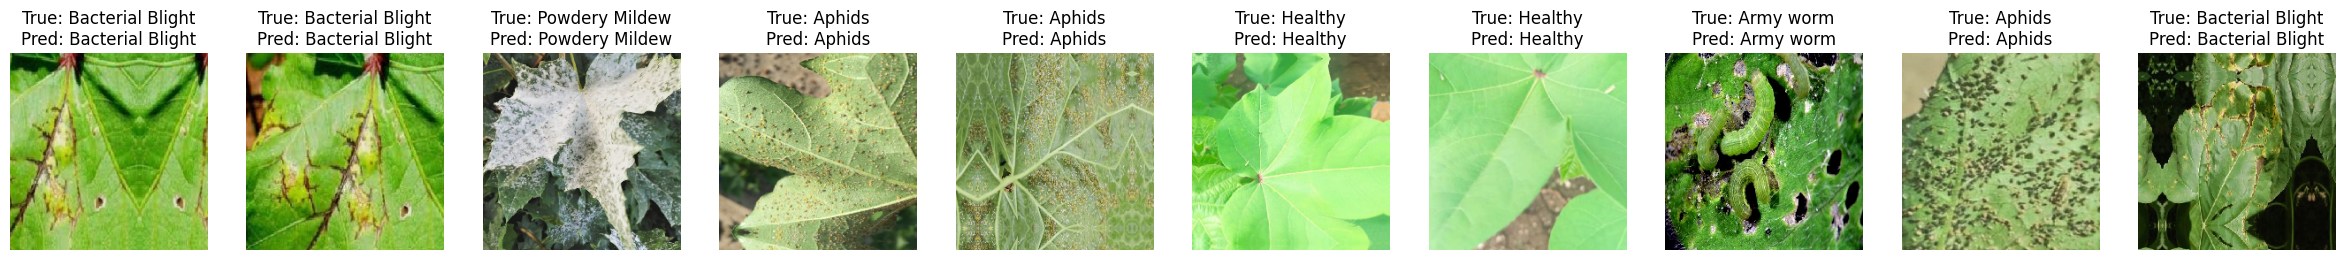

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_gen.class_indices is available
class_names = list(all_gen.class_indices.keys())
reverse_class_names = {v: k for k, v in all_gen.class_indices.items()}

# ---------------------------
# Prediction & Visualization using Teacher Model
# ---------------------------

def predict_and_visualize(model, X_test, y_test, num_images=5):
    # Get predictions for all test images
    predictions = model.predict(X_test)  # Get all predictions
    
    # Get the true labels as indices
    true_labels = np.argmax(y_test, axis=1)
    
    # Plot a few images with their predictions
    plt.figure(figsize=(30, 30))
    
    for i in range(num_images):
        rand_idx = np.random.randint(0, len(X_test))
        image = X_test[rand_idx]
        true_label_idx = true_labels[rand_idx]
        predicted_class_idx = np.argmax(predictions[rand_idx])
        
        true_label = reverse_class_names[true_label_idx]
        predicted_label = reverse_class_names[predicted_class_idx]
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
    
    plt.show()

# 👇 Call this with the teacher model
predict_and_visualize(teacher_model, X_test, y_test, num_images=10)


## Student Model

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step


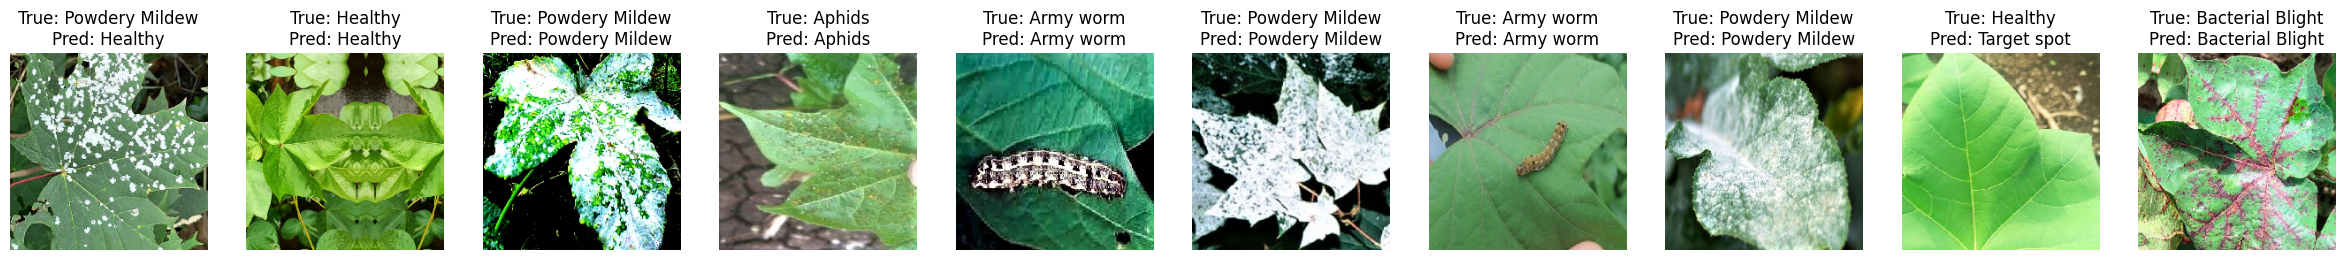

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_gen.class_indices is available
class_names = list(all_gen.class_indices.keys())
reverse_class_names = {v: k for k, v in all_gen.class_indices.items()}

# ---------------------------
# Prediction & Visualization using Student Model
# ---------------------------

def predict_and_visualize_student(model, X_test, y_test, num_images=5):
    predictions = model.predict(X_test)  # Get predictions from student model
    true_labels = np.argmax(y_test, axis=1)

    plt.figure(figsize=(30, 30))

    for i in range(num_images):
        rand_idx = np.random.randint(0, len(X_test))
        image = X_test[rand_idx]
        true_label_idx = true_labels[rand_idx]
        predicted_class_idx = np.argmax(predictions[rand_idx])

        true_label = reverse_class_names[true_label_idx]
        predicted_label = reverse_class_names[predicted_class_idx]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {predicted_label}")

    plt.show()

# 🔍 Visualize predictions from the Student Model
predict_and_visualize_student(student_model, X_test, y_test, num_images=10)



--- Teacher Model (DenseNet121) Evaluation ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 759ms/step
Accuracy: 96.67%

Classification Report:
                  precision    recall  f1-score   support

          Aphids       0.97      0.95      0.96       126
       Army worm       0.98      0.97      0.98       123
Bacterial Blight       0.94      0.96      0.95       125
         Healthy       0.98      0.98      0.98       112
  Powdery Mildew       0.95      0.99      0.97       119
     Target spot       0.98      0.95      0.96       116

        accuracy                           0.97       721
       macro avg       0.97      0.97      0.97       721
    weighted avg       0.97      0.97      0.97       721



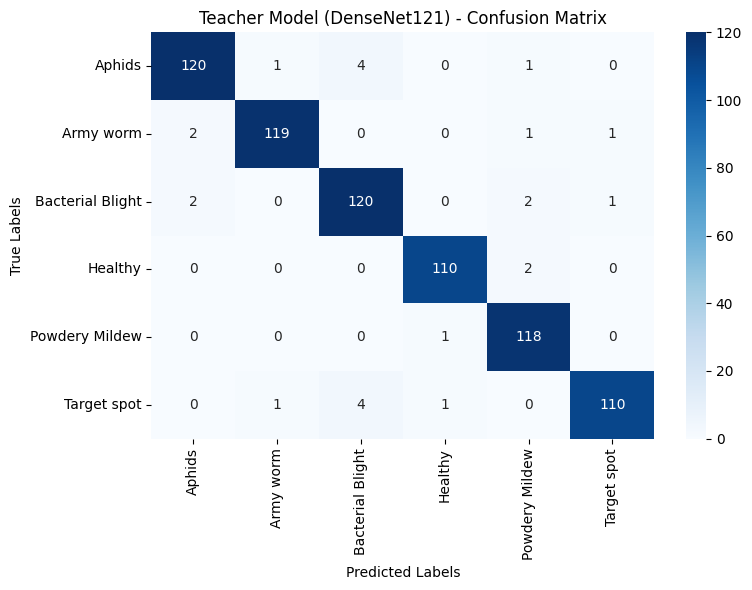


--- Student Model (MobileNetV2) Evaluation ---
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step
Accuracy: 91.96%

Classification Report:
                  precision    recall  f1-score   support

          Aphids       0.95      0.79      0.87       126
       Army worm       0.99      0.97      0.98       123
Bacterial Blight       0.80      0.97      0.87       125
         Healthy       0.96      0.96      0.96       112
  Powdery Mildew       0.92      0.98      0.95       119
     Target spot       0.94      0.85      0.90       116

        accuracy                           0.92       721
       macro avg       0.93      0.92      0.92       721
    weighted avg       0.93      0.92      0.92       721



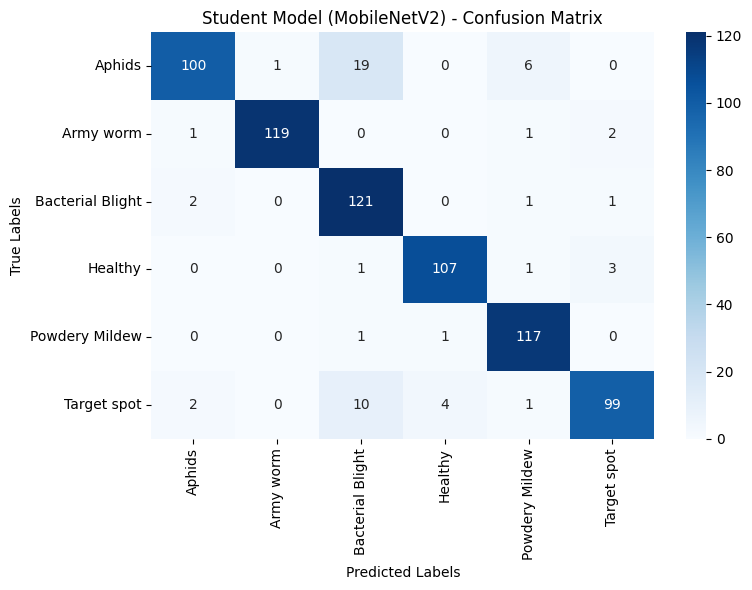

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Reverse Class Names from Generator
class_names = list(all_gen.class_indices.keys())
reverse_class_names = {v: k for k, v in all_gen.class_indices.items()}

# 2. Define the Evaluation Function
def evaluate_model(model, X, y_true, model_name="Model"):
    print(f"\n--- {model_name} Evaluation ---")
    
    # Get predicted probabilities and predicted classes
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_true, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

# 3. Run Evaluation for Both Models
evaluate_model(teacher_model, X_test, y_test, model_name="Teacher Model (DenseNet121)")
evaluate_model(student_model, X_test, y_test, model_name="Student Model (MobileNetV2)")
